# Loading libraries

In [35]:
import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pycaret.classification import setup, compare_models
from sklearn.metrics import classification_report
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# Useful functions for analysis

In [2]:
def missing_columns(df):
    data = df.copy()
    columns = data.columns
    results = pd.DataFrame([],columns = ['Feature','Missing','Percent'])
    for column in columns:
        count = data[column].isnull().sum()
        if count != 0:
            percent = round(100*count/len(data[column]),2)
            results.loc[len(results)] = [column, count, percent]
    results = results.sort_values('Missing', ascending = False)
    return results

def percent_uncertainty(dframe, values, errors):
    total = len(dframe)
    results = pd.DataFrame([],columns = ['Mean','Median','5%','10%','20%','50%','100%'])
    for error, value in zip(errors, values):
        temp = (100*dframe[error])/dframe[value]
        mn = np.nanmean(dframe[value])
        md = np.nanmedian(dframe[value])
        five = 100*len(temp[temp > 5])/total
        ten = 100*len(temp[temp > 10])/total
        twenty = 100*len(temp[temp > 20])/total
        fifty = 100*len(temp[temp > 50])/total
        hundred = 100*len(temp[temp > 100])/total
        temp_series = pd.Series([mn, md, five, ten, twenty, fifty, hundred], index = ['Mean','Median','5%','10%','20%','50%','100%'], name = value)
        results = results.append(temp_series)
        results = results.astype(float).round(2)
    # results produces a dataframe that where each column represents what % of the number of entries would be
    # removed if you were to exclude entries with an uncertainty greater than a certain % of the measurement.
    # e.g. the 50% column shows how many datapoints have an uncertainty of magnitude 50% or greater than the value.
    return results

def clf_results(Classifier,dfX,dfy, labels):
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix
    from sklearn.model_selection import cross_validate
    from sklearn.metrics import recall_score
    X = dfX.copy()
    y = dfy.copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
    clf = Classifier().fit(X_train, y_train.values.ravel())
    predictions = clf.predict(X_test)
    scoring = ['precision_macro', 'recall_macro']
    scores = cross_validate(clf, X, y.values.ravel(), scoring=scoring, cv=5, return_train_score=True)
    cv = pd.DataFrame([scores['train_precision_macro'], scores['test_precision_macro'], scores['train_recall_macro'], scores['test_recall_macro']], index = ['Precision:train','Precision:test','Recall:train','Recall:test'])
    print(cv)
    conf = pd.DataFrame(confusion_matrix(y_test, predictions,labels = labels), index=['T:{:}'.format(x) for x in labels], columns=['P:{:}'.format(x) for x in labels])
    print(conf)
    if hasattr(clf, 'feature_importances_'):
        imp = pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns = ['Importance']).sort_values(by = 'Importance',ascending = False)
        print(imp)

# Load the data

In [3]:
dat = Table.read('GALAH_DR3_main_allstar_v2.fits', format = 'fits')
galah = dat.to_pandas()
stars_original = len(galah)

# Investigating and cleaning the data

In [4]:
# Looking at the features included in the catalogue, they can be grouped into four types:

# Measurements potentially useful for ML analysis. Some data cleaning may be required but it is doubtful that any 
# of the measurements will be removed totally.

# Measurements of spectral lines that may be useful. These are separate from the non-spectral line measurements as
# they are not always measurable, or even present, in some spectra. However, not being present (or measurable) in 
# itself is a value of zero. As such the missing values will be replaced with zeros.
   
# Uncertainties for the measurements which, while not directly useful for the analysis, can be useful for removing
# outliers.

# Non-informative features, such as id's for stars. These have no relationship to spectral class and can be removed
# to save memory and improve performance.

In [5]:
# The first step is to look at all features and see which have missing entries and how many are missing.
missing_columns(galah)

,Feature,Missing,Percent
50,Sc2_fe,588571,100.00
65,e_Cr2_fe,588571,100.00
51,e_Sc2_fe,588571,100.00
64,Cr2_fe,588571,100.00
96,Ru_fe,558422,94.88
97,e_Ru_fe,558422,94.88
93,Mo_fe,549849,93.42
94,e_Mo_fe,549849,93.42
82,e_Rb_fe,526437,89.44
81,Rb_fe,526437,89.44


In [6]:
# Each useful feature can be placed into separate lists, for further analysis.

# While teff and logg are useful measurements, they will be used to produce the labels. Using these measurements as
# features could produce a bias that where the classifier would use these features over the rest as the way of 
# predicting the classes.

# There are some measurements which are highly incomplete, rv_gaia_dr2, and it's uncertainty, e_rv_gaia_dr2.
# As more than 50% are missing, it would be misleading to fill in these values, so the features will be dropped.

# Additionally, irfm_ebv and irfm_teff contain ~10% missing entries. irfm_ebv is not a measurement of a star itself,
# but is instead a measurement of the space between the star and Earth. It is used to estimate irfm_teff, which is 
# an alternative teff measurement. As we are already using teff, irfm_teff and irfm_ebv can be safely dropped.

# One last group of features to drop are the signal-to-noise snr_cX_iraf features (where X can be 1-4 and is the 
# number of the camera used). The signal-to-noise would  be factored into the uncertainty estimation of each 
# measurement, so they are not needed.
features = ['vmic', 'vbroad', 'rv_galah', 'v_jk','j_m','h_m','ks_m','w2mpro','parallax_dr2','ruwe_dr2']

# The spectral lines Sc2_fe, Cr2_fe and their errors are 100% missing and can be removed from consideration.
elements = ['fe_h','alpha_fe','Li_fe','C_fe','O_fe','Na_fe','Mg_fe','Al_fe','Si_fe','K_fe','Ca_fe','Sc_fe','Ti_fe','Ti2_fe','V_fe','Cr_fe','Mn_fe','Co_fe','Ni_fe','Cu_fe','Zn_fe','Rb_fe','Sr_fe','Y_fe','Zr_fe','Mo_fe','Ru_fe','Ba_fe','La_fe','Ce_fe','Nd_fe','Sm_fe','Eu_fe']

In [7]:
# Removing the missing rows from the catalogue has reduced it by 6.3%. While this is a non-trivial amount, 
# the catalogue is large enough to support this and still be relevant.
before = len(galah)
galah = galah.dropna(subset = features)
after = len(galah)
diff = round((100*(before-after))/before,2)
print('        Before: ' + str(before))
print('After cleaning: ' + str(after))
print('          Loss: ' + str(diff) + '%')

        Before: 588571
After cleaning: 551481
          Loss: 6.3%


In [8]:
# Due to the large number of stars observed, the GALAH catalogue does not contain classification of each star.
# This is the task of this work. To do this the effective temperature, teff, and surface gravity, logg, can be used
# to produce a mock classifiaction that, while not 100% accurate, will be sufficient for this task.
# The maximum teff that GALAH can determine from the data is 8000K. A-stars span across this limit, and O and B
# stars occur well past the limit. As such, only stars from M to F are considered.
# Cool A-stars that fall below the limit had to be removed. 
galah = galah[galah['teff'] < 7320]

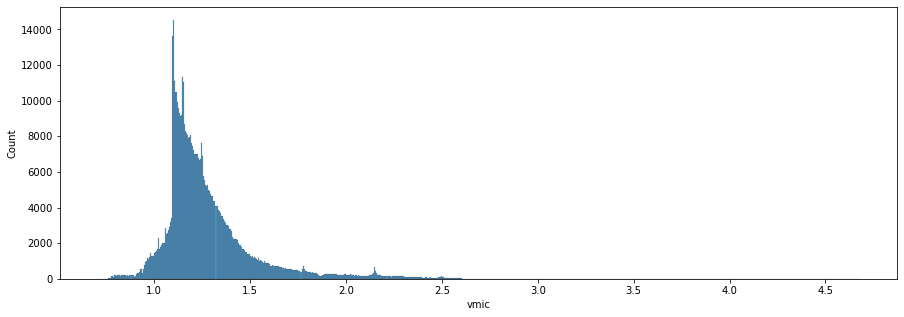

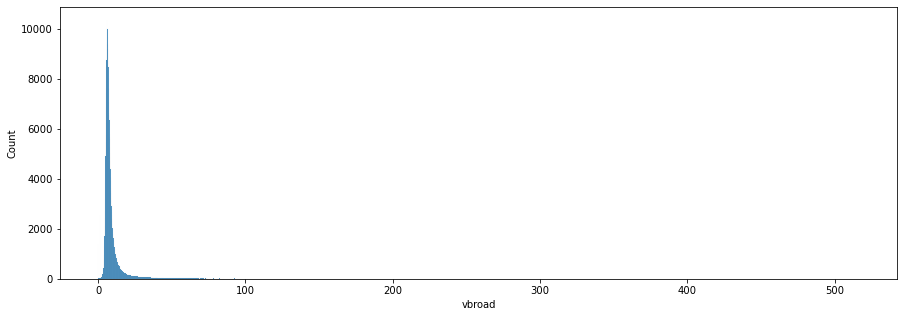

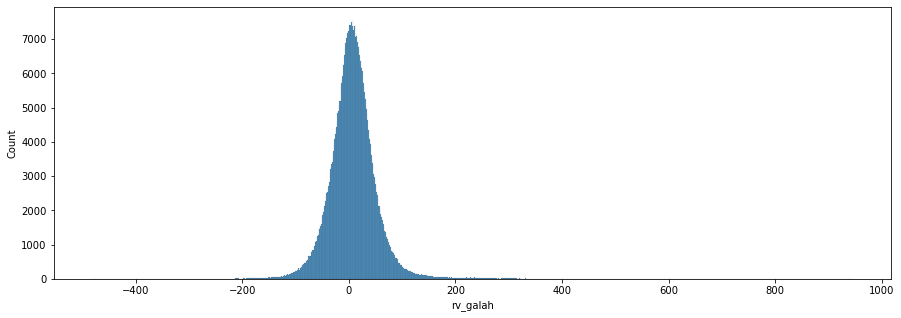

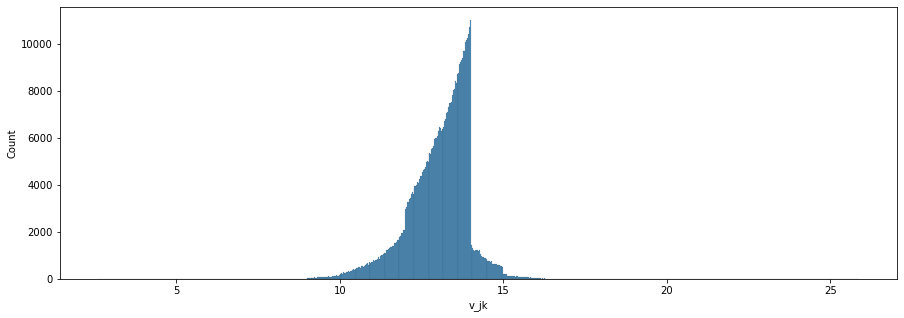

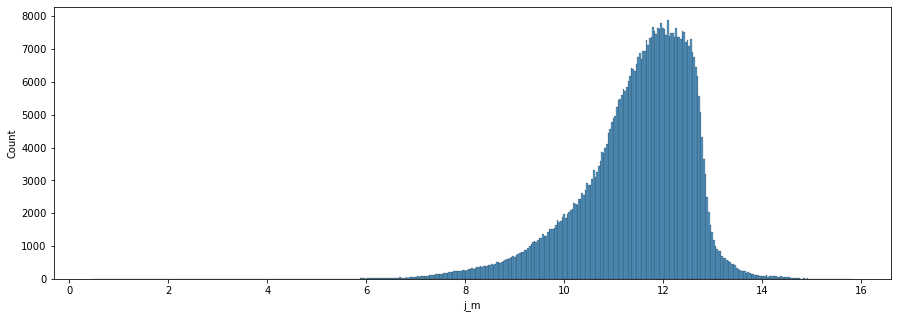

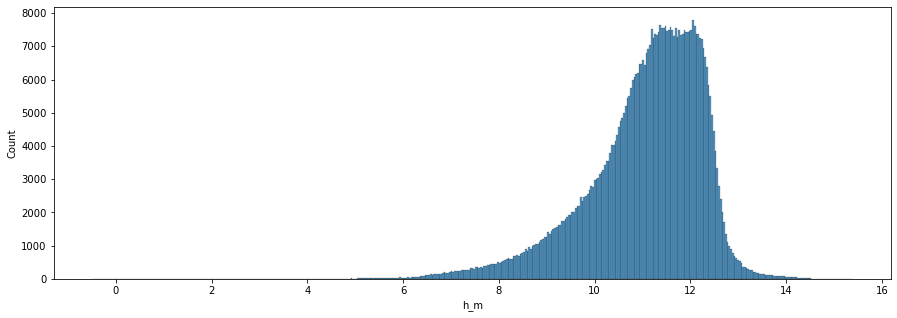

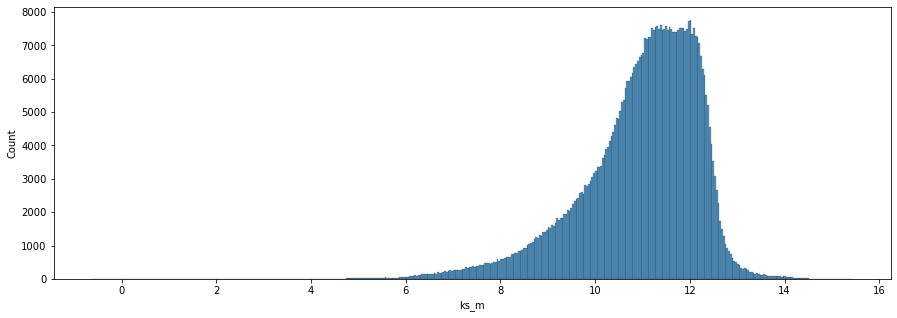

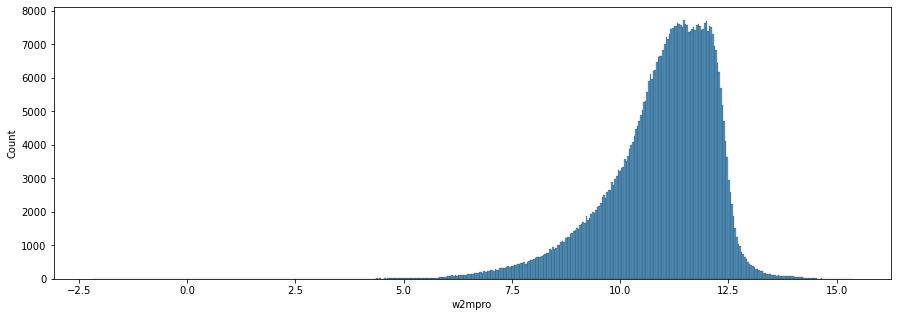

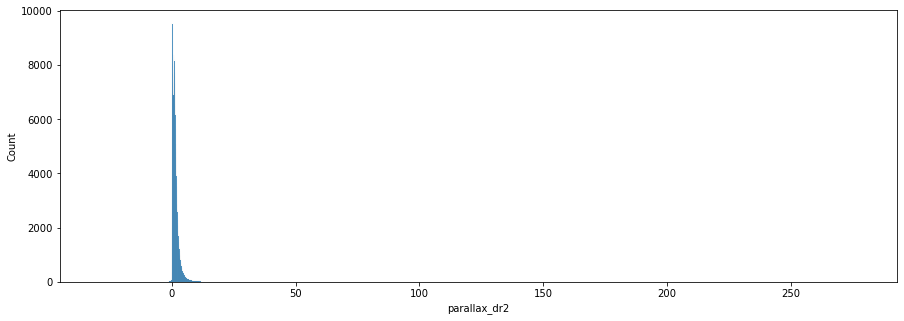

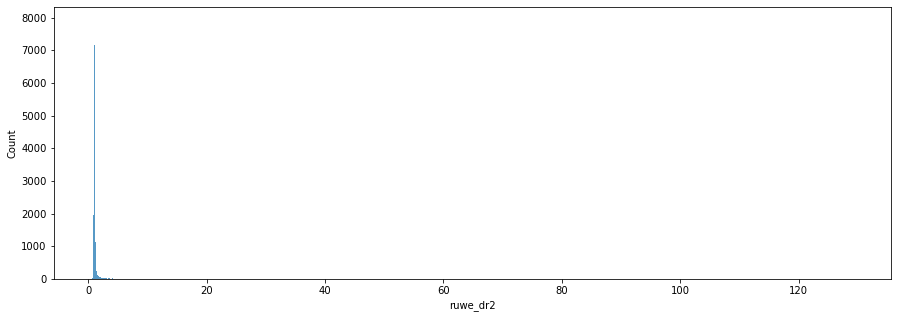

In [9]:
# Each of the non-spectral line features need to be visually investigated to check for outliers.
# Limits are generous to only exclude exteme values.
for feature in features:
    plt.figure(figsize = [15,5])
    sns.histplot(data = galah, x = feature);


In [10]:
# Removing these extreme values removes almost 2% of the catalogue.
before = len(galah)
galah = galah[galah['vmic'] < 3]
galah = galah[galah['vbroad'] < 100]
galah = galah[np.abs(galah['rv_galah']) < 400]
galah = galah[(galah['v_jk'] > 5) & (galah['v_jk'] < 20)]
galah = galah[np.abs(galah['j_m']) > 5]
galah = galah[np.abs(galah['h_m']) > 4]
galah = galah[np.abs(galah['ks_m']) > 4]
galah = galah[np.abs(galah['w2mpro']) > 2.5]
galah = galah[(galah['parallax_dr2'] > 0) & (galah['parallax_dr2'] < 20)]
galah = galah[(galah['ruwe_dr2'] > 0) & (galah['ruwe_dr2'] < 10)]
after = len(galah)
diff = round((100*(before-after))/before,2)
print('        Before: ' + str(before))
print('After cleaning: ' + str(after))
print('          Loss: ' + str(diff) + '%')

        Before: 545770
After cleaning: 535974
          Loss: 1.79%


In [11]:
# To test the non-spectral line features that have corresponding uncertainties, the percentage uncertainty will be
# analysed. This will highlight how many entries have measurements with significantly large uncertainties.
fea_values = ['teff', 'logg', 'vbroad', 'rv_galah']
fea_errors = ['e_teff', 'e_logg', 'e_vbroad', 'e_rv_galah']
percent_uncertainty(galah, fea_values, fea_errors)

,Mean,Median,5%,10%,20%,50%,100%
teff,5387.29,5510.63,0.82,0.05,0.00,0.00,0.00
logg,3.57,3.99,43.07,14.47,4.11,0.78,0.18
vbroad,9.60,7.08,99.29,96.16,85.98,7.38,0.83
rv_galah,7.76,6.60,4.73,2.65,1.41,0.58,0.28


In [12]:
before = len(galah)
# Teff has low magnitude uncertainties and the removal of entries with uncertainties greater than 5% will be fine.
galah = galah[100*galah['e_teff']/galah['teff'] < 5]
# Logg is more difficult to measure accurately, and this is reflected in the uncertainties.
# A 50% cutoff is a reasonable balance of stars removed to highly uncertain measurements.
galah = galah[100*galah['e_logg']/galah['logg'] < 50]
# Most of the uncertainties in vbroad are in the 0-20% range. However 50% gives 7.3%, which is still a bit too high.
# A cutoff of errors greater than the value itself (100%) is safest.
galah = galah[100*galah['e_vbroad']/galah['vbroad'] < 100]
# The rv_galah measurement, while not as accurate as teff, is still quite reliable. The cutoff will be 20%.
galah = galah[100*galah['e_rv_galah']/galah['rv_galah'] < 20]
after = len(galah)
diff = round((100*(before-after))/before,2)
print('        Before: ' + str(before))
print('After cleaning: ' + str(after))
print('          Loss: ' + str(diff) + '%')

        Before: 535974
After cleaning: 514239
          Loss: 4.06%


In [13]:
# Replacing the missing values in the spectral line measurements with zero.
galah[elements] = galah[elements].fillna(value = 0.0)

In [14]:
# Checking the magnitude of the uncertainties for the spectral line measurements.
ele_values = ['fe_h','alpha_fe','Li_fe','C_fe','O_fe','Na_fe','Mg_fe','Al_fe','Si_fe','K_fe','Ca_fe','Sc_fe','Ti_fe','Ti2_fe','V_fe','Cr_fe','Mn_fe','Co_fe','Ni_fe','Cu_fe','Zn_fe','Rb_fe','Sr_fe','Y_fe','Zr_fe','Mo_fe','Ru_fe','Ba_fe','La_fe','Ce_fe','Nd_fe','Sm_fe','Eu_fe']
ele_errors = ['e_fe_h','e_alpha_fe','e_Li_fe','e_C_fe','e_O_fe','e_Na_fe','e_Mg_fe','e_Al_fe','e_Si_fe','e_K_fe','e_Ca_fe','e_Sc_fe','e_Ti_fe','e_Ti2_fe','e_V_fe','e_Cr_fe','e_Mn_fe','e_Co_fe','e_Ni_fe','e_Cu_fe','e_Zn_fe','e_Rb_fe','e_Sr_fe','e_Y_fe','e_Zr_fe','e_Mo_fe','e_Ru_fe','e_Ba_fe','e_La_fe','e_Ce_fe','e_Nd_fe','e_Sm_fe','e_Eu_fe']
percent_uncertainty(galah, ele_values, ele_errors)

,Mean,Median,5%,10%,20%,50%,100%
fe_h,-0.19,-0.16,26.92,26.87,25.52,17.44,10.39
alpha_fe,0.08,0.05,75.76,73.05,62.63,38.95,20.99
Li_fe,0.58,0.35,52.76,29.03,13.94,5.14,2.47
C_fe,0.13,0.00,40.05,39.99,37.04,22.46,12.00
O_fe,0.17,0.12,68.84,68.52,64.02,40.45,22.12
Na_fe,0.08,0.07,73.16,72.23,67.30,44.64,22.87
Mg_fe,0.07,0.04,61.33,61.09,57.61,42.52,26.90
Al_fe,0.15,0.12,75.67,73.97,64.20,35.78,18.24
Si_fe,0.08,0.05,69.47,68.81,63.76,43.93,26.68
K_fe,0.07,0.03,56.99,56.41,53.57,39.60,23.92


In [15]:
# While many of the element measurements contain significant (>20%) uncertainties, to remove entries with large
# uncertainties would reduce the catalogue to a small fraction of its original size. 
# As such, no cleaning will be done.
stars_cleaned = len(galah)
diff = round((100*(stars_original-stars_cleaned))/stars_original,2)
print('        Before: ' + str(stars_original))
print('After cleaning: ' + str(stars_cleaned))
print('          Loss: ' + str(diff) + '%')
# Overall, the cleaning has reduced the catalogue by almost 13%. As there are hundreds of thousands of entries,
# this will not impact the results significantly.

        Before: 588571
After cleaning: 514239
          Loss: 12.63%


In [16]:
# Once the spectral lines with too many missing entries have been removed, the rest can be added to the feature list. 
features = features + elements

In [17]:
# All missing entries have been excluded or replaced.
missing_columns(galah[features])

,Feature,Missing,Percent


# Creation of target labels

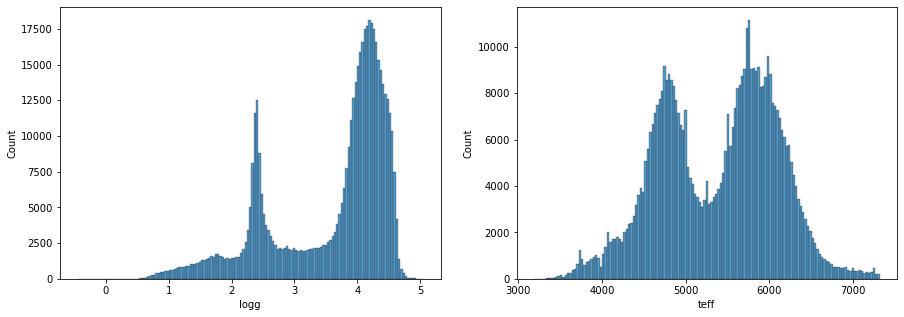

In [18]:
# Looking at the effective temperature and gravity, there are two distinct populations present.
# The gravity plot higlights the giant stars as the lower peak and the dwarfs as the larger value peak.
# The temperature peaks are not as well separated as the gravities. This suggests it could be two dominant
# populations, or an overall normal (Gaussian) distribution with a significant amount of the peak missing.
# Regardless, temperature and gravity are well suited to a rough stellar classification.
fig = plt.figure(figsize = [15,5])
plt.subplot(1,2,1)
sns.histplot(data = galah, x = 'logg');
plt.subplot(1,2,2)
sns.histplot(data = galah, x = 'teff');

In [19]:
# Dwarfs
# Taken from https://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt
MD = galah[(galah['teff'] >= 2450) & (galah['teff'] < 3865) & (galah['logg'] >= 4.2) & (galah['logg'] < 5.4)]
KD = galah[(galah['teff'] >= 3865) & (galah['teff'] < 5310) & (galah['logg'] >= 4.2) & (galah['logg'] < 5.4)]
GD = galah[(galah['teff'] >= 5310) & (galah['teff'] < 5980) & (galah['logg'] >= 4.2) & (galah['logg'] < 5.4)]
FD = galah[(galah['teff'] >= 5980) & (galah['teff'] < 7320) & (galah['logg'] >= 4.2) & (galah['logg'] < 5.4)]
dwarfs = {'MD':MD,'KD':KD,'GD':GD,'FD':FD}
# Giants
MG = galah[(galah['teff'] >= 2450) & (galah['teff'] < 3865) & (galah['logg'] < 4.2)]
KG = galah[(galah['teff'] >= 3865) & (galah['teff'] < 5310) & (galah['logg'] < 4.2)]
GG = galah[(galah['teff'] >= 5310) & (galah['teff'] < 5980) & (galah['logg'] < 4.2)]
FG = galah[(galah['teff'] >= 5980) & (galah['teff'] < 7320) & (galah['logg'] < 4.2)]
giants = {'MG':MG,'KG':KG,'GG':GG,'FG':FG}
classes = [*dwarfs.keys(), *giants.keys()]

In [20]:
all_stars = len(galah)
stars = pd.DataFrame([],columns = ['Quantity','Percent'])
for name, dwarf in dwarfs.items():
    quantity = len(dwarf)
    percent = round((100*quantity)/all_stars,2)
    temp = pd.Series([quantity, percent], index = ['Quantity', 'Percent'], name = name)
    stars = stars.append(temp)
for name, giant in giants.items():
    quantity = len(giant)
    percent = round((100*quantity)/all_stars,2)
    temp = pd.Series([quantity, percent], index = ['Quantity', 'Percent'], name = name)
    stars = stars.append(temp)
temp = pd.Series([stars['Quantity'].sum(), stars['Percent'].sum()], index = ['Quantity', 'Percent'], name = 'Total')
stars = stars.append(temp)
stars['Quantity'] = stars['Quantity'].astype(int)
stars

,Quantity,Percent
MD,1938,0.38
KD,41188,8.01
GD,90583,17.61
FD,29353,5.71
MG,4924,0.96
KG,175840,34.19
GG,83941,16.32
FG,86472,16.82
Total,514239,100.00


In [21]:
data = galah[features]
conds = [(galah['teff'] >= 2450) & (galah['teff'] < 3865) & (galah['logg'] >= 4.2) & (galah['logg'] < 5.4), (galah['teff'] >= 3865) & (galah['teff'] < 5310) & (galah['logg'] >= 4.2) & (galah['logg'] < 5.4), (galah['teff'] >= 5310) & (galah['teff'] < 5980) & (galah['logg'] >= 4.2) & (galah['logg'] < 5.4), (galah['teff'] >= 5980) & (galah['teff'] < 7320) & (galah['logg'] >= 4.2) & (galah['logg'] < 5.4), (galah['teff'] >= 2450) & (galah['teff'] < 3865) & (galah['logg'] < 4.2), (galah['teff'] >= 3865) & (galah['teff'] < 5310) & (galah['logg'] < 4.2), (galah['teff'] >= 5310) & (galah['teff'] < 5980) & (galah['logg'] < 4.2), (galah['teff'] >= 5980) & (galah['teff'] < 7320) & (galah['logg'] < 4.2)]
data['class'] = np.select(conds, classes)
test = data.iloc[0:9999]

# Testing ML algorithms on the data

In [30]:
setup(data = test, target = 'class')

,Description,Value
0,session_id,8735
1,Target,class
2,Target Type,Multiclass
3,Label Encoded,"FD: 0, FG: 1, GD: 2, GG: 3, KD: 4, KG: 5, MD: 6, MG: 7"
4,Original Data,"(9999, 44)"
5,Missing Values,False
6,Numeric Features,43
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


(False,
 {'acc': <pycaret.containers.metrics.classification.AccuracyMetricContainer at 0x7f2ede85af10>,
  'auc': <pycaret.containers.metrics.classification.ROCAUCMetricContainer at 0x7f2ede85afd0>,
  'recall': <pycaret.containers.metrics.classification.RecallMetricContainer at 0x7f2ede85af50>,
  'precision': <pycaret.containers.metrics.classification.PrecisionMetricContainer at 0x7f2ede879190>,
  'f1': <pycaret.containers.metrics.classification.F1MetricContainer at 0x7f2ede7a8b50>,
  'kappa': <pycaret.containers.metrics.classification.KappaMetricContainer at 0x7f2ede7a8d10>,
  'mcc': <pycaret.containers.metrics.classification.MCCMetricContainer at 0x7f2ede7a8d90>},
 StratifiedKFold(n_splits=10, random_state=8735, shuffle=False),
 True,
 False,
 -1,
 'clf-default-name',
 8074     5
 852      5
 8099     0
 11596    5
 11898    5
         ..
 12106    1
 6334     3
 11397    2
 3524     2
 4936     5
 Name: class, Length: 3000, dtype: int64,
 5,
 -1,
 'class',
 [('Setup Config',
        

In [31]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9713,0.9993,0.9315,0.9715,0.9707,0.9584,0.9585,71.7320
catboost,CatBoost Classifier,0.9693,0.9992,0.9167,0.9697,0.9689,0.9555,0.9556,20.2700
lightgbm,Light Gradient Boosting Machine,0.9686,0.9991,0.9108,0.9689,0.9681,0.9544,0.9545,445.8460
gbc,Gradient Boosting Classifier,0.9624,0.9984,0.9143,0.9623,0.9617,0.9455,0.9456,4.5190
rf,Random Forest Classifier,0.9470,0.9977,0.8579,0.9474,0.9428,0.9226,0.9233,0.2650
dt,Decision Tree Classifier,0.9350,0.9586,0.8910,0.9366,0.9352,0.9060,0.9062,0.0430
et,Extra Trees Classifier,0.9086,0.9940,0.7475,0.9085,0.8975,0.8653,0.8671,0.1440
lda,Linear Discriminant Analysis,0.8720,0.9856,0.7894,0.8885,0.8767,0.8159,0.8167,0.0190
ridge,Ridge Classifier,0.8113,0.0000,0.4230,0.7707,0.7632,0.7146,0.7236,0.0150
svm,SVM - Linear Kernel,0.7617,0.0000,0.4058,0.7603,0.7396,0.6508,0.6586,0.0440


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=8735, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='auto',
              use_label_encoder=True, validate_parameters=1, verbosity=0)

/home/john/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/john/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/john/anaconda3/lib/python3.7/site-packages/pycaret/internal/pipeline.py", line 118, in fit
    result = super().fit(X, y=y, **fit_kwargs)
  File "/home/john/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/home/john/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/home/john/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", lin

/home/john/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/john/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/john/anaconda3/lib/python3.7/site-packages/pycaret/internal/pipeline.py", line 118, in fit
    result = super().fit(X, y=y, **fit_kwargs)
  File "/home/john/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/home/john/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/home/john/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", lin

/home/john/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/john/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
X = galah[features]
y = np.select(conds, classes)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 0)
params = {'eta':[0.2,0.4,0.6,0.8,1.0]}
clf = xgb.XGBClassifier(random_state=0)
grid = GridSearchCV(clf, param_grid = params)
grid.fit(X_train,y_train)
print(grid.best_params_)

[13:47:24] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:47:38] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:48:02] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:48:19] WARNING: /tmp/abs_40obctay9q/croots/re

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
               

In [34]:
clf = xgb.XGBClassifier(eta = 0.2, random_state=0).fit(X_train,y_train)
predictions = clf.predict(X_test)

[14:28:16] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [38]:
np.unique(predictions, return_counts=True)

(array(['FD', 'FG', 'GD', 'GG', 'KD', 'KG', 'MD', 'MG'], dtype='<U21'),
 array([ 7347, 21439, 22666, 20995, 10362, 44025,   473,  1253]))

In [41]:
test = classification_report(y_test, predictions)
test

'              precision    recall  f1-score   support\n\n          FD       1.00      1.00      1.00      7347\n          FG       1.00      1.00      1.00     21439\n          GD       1.00      1.00      1.00     22666\n          GG       1.00      1.00      1.00     20995\n          KD       1.00      1.00      1.00     10362\n          KG       1.00      1.00      1.00     44025\n          MD       1.00      1.00      1.00       473\n          MG       1.00      1.00      1.00      1253\n\n    accuracy                           1.00    128560\n   macro avg       1.00      1.00      1.00    128560\nweighted avg       1.00      1.00      1.00    128560\n'

In [23]:
include = features = ['teff','logg']
data = galah[include]
conds = [(galah['teff'] >= 2450) & (galah['teff'] < 3865) & (galah['logg'] >= 4.2) & (galah['logg'] < 5.4), (galah['teff'] >= 3865) & (galah['teff'] < 5310) & (galah['logg'] >= 4.2) & (galah['logg'] < 5.4), (galah['teff'] >= 5310) & (galah['teff'] < 5980) & (galah['logg'] >= 4.2) & (galah['logg'] < 5.4), (galah['teff'] >= 5980) & (galah['teff'] < 7320) & (galah['logg'] >= 4.2) & (galah['logg'] < 5.4), (galah['teff'] >= 2450) & (galah['teff'] < 3865) & (galah['logg'] < 4.2), (galah['teff'] >= 3865) & (galah['teff'] < 5310) & (galah['logg'] < 4.2), (galah['teff'] >= 5310) & (galah['teff'] < 5980) & (galah['logg'] < 4.2), (galah['teff'] >= 5980) & (galah['teff'] < 7320) & (galah['logg'] < 4.2)]
data['class'] = np.select(conds, classes)
data = pd.get_dummies(data, columns = ['class'])
correlations = data.corr()
for c in classes:
    temp = correlations['class_' + c].sort_values(key=abs, ascending = False)
    print(c)
    print(temp[1:5])

MD
teff       -0.151786
logg        0.064892
class_KG   -0.044336
class_GD   -0.028440
Name: class_MD, dtype: float64
KD
logg        0.295279
class_KG   -0.212704
teff       -0.207043
class_GD   -0.136442
Name: class_KD, dtype: float64
GD
logg        0.389814
class_KG   -0.333320
class_FG   -0.207898
class_GG   -0.204230
Name: class_GD, dtype: float64
FD
teff        0.273993
logg        0.186205
class_KG   -0.177358
class_GD   -0.113769
Name: class_FD, dtype: float64
MG
logg       -0.266311
teff       -0.231630
class_KG   -0.070878
class_GD   -0.045466
Name: class_MG, dtype: float64
KG
logg       -0.818414
teff       -0.716635
class_GD   -0.333320
class_FG   -0.324100
Name: class_KG, dtype: float64
GG
class_KG   -0.318381
teff        0.207877
class_GD   -0.204230
class_FG   -0.198580
Name: class_GG, dtype: float64
FG
teff        0.582996
class_KG   -0.324100
class_GD   -0.207898
class_GG   -0.198580
Name: class_FG, dtype: float64
